In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as la
from numpy import random as rand
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp
import scipy.special as sp

%matplotlib inline

# Data Analysis

In [593]:
##Param
mu=.2; ##efficiency
N=24; ##FoodWebs

##Outputs
qvec=np.zeros(N); ##trophic coherence
Rvec=np.zeros(N); ##leading eig
Svec=np.zeros(N); ##number of species
Cvec=np.zeros(N); ##complexity

##Main
for kk in xrange(N):
    
    ##Import data
    da = pd.read_excel("FoodWebs/" + str(kk+1) + ".xls");
    A  = da.as_matrix();
    
    ##Output S and C
    n, n = np.shape(A); ##size
    np.fill_diagonal(A,np.zeros(n))
    L=sum(sum(A)); ## Links
    
    Svec[kk] = n;
    Cvec[kk] = float(L)/n**2; 
    
    ##Eigenvec R
    W = mu*A-np.transpose(A);
    lamb = la.eigvals(W); 
    Rvec[kk] = max(np.real(lamb));

    ###---TROPHIC COHERENCE---###
    
    ##Linear System
    vvec=np.zeros(n);
    for ii in xrange(n):
        vvec[ii]=max([sum(A[ii,:]),1]);
    D=np.diag(vvec)-A;

    ##QR Method
    Q, R = la.qr(D) 
    yvec = np.dot(Q.T, vvec)
    ##Trophic levels
    svec = la.solve(R, yvec)

    ##Trophic distance
    X=0;
    for ii in xrange(n):
        for jj in xrange(n):
            if A[ii,jj] == 1: 
                x = svec[ii] - svec[jj]; x = x**2; 
                X = X + x;

    ##Trophic Coherence
    qvec[kk]=np.sqrt(X/L - 1);    

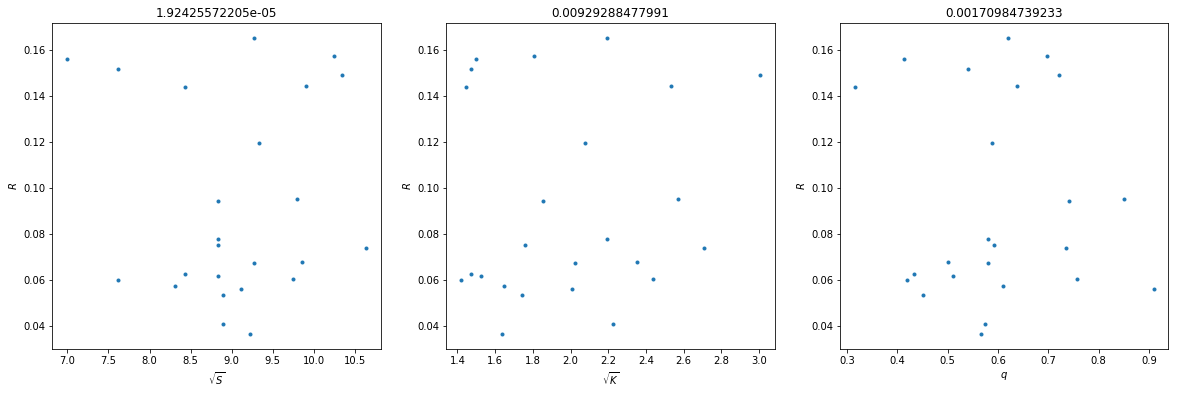

In [594]:
N=24; ##FoodWebs

##Figures

plt.figure(1);
plt.figure(figsize=(20,6))

Rm=sum(Rvec)/N;

Svec=np.sqrt(Svec)
plt.subplot(1,3,1);
plt.plot(Svec,Rvec,'.');
plt.xlabel('$\sqrt{S}$');
plt.ylabel('$R$');

Sm=sum(Svec)/N;
r=sum((Rvec-Rm)*(Svec-Sm))/(np.sqrt(sum((Rvec-Rm)**2))*np.sqrt(sum((Svec-Sm)**2)));
plt.title(str(r**2));

Cvec=np.sqrt(Cvec);
Kvec=Cvec*Svec;
plt.subplot(1,3,2);
plt.plot(Kvec,Rvec,'.');
plt.xlabel('$\sqrt{K}$');
plt.ylabel('$R$');

Km=sum(Kvec)/N;
r=sum((Rvec-Rm)*(Kvec-Km))/(np.sqrt(sum((Rvec-Rm)**2))*np.sqrt(sum((Kvec-Km)**2)));
plt.title(str(r**2));

plt.subplot(1,3,3);
plt.plot(qvec,Rvec,'.');
plt.xlabel('$q$');
plt.ylabel('$R$');

qm=sum(qvec)/N;
r=sum((Rvec-Rm)*(qvec-qm))/(np.sqrt(sum((Rvec-Rm)**2))*np.sqrt(sum((qvec-qm)**2)));
plt.title(str(r**2));

# PPM

In [455]:
##Basal species
##Total species
##Complexity
##Trophic specialitzation

def PPM(B,S,C,T):
    Lt=int(C*S**2); ##Total Expected Links
    L = float(Lt)/S; ##expected links per species
    G=nx.DiGraph(); ## Start with an empty graph
    G.add_nodes_from(list(range(B)))
    jj=B; # Start adding the other S-B nodes. 

    sl=np.ones(B);

    while jj<S:

        target=rand.randint(0,jj,1); ## First node
    
        pvec=np.exp(-abs(sl[target]-sl)/T); pvec[target]=0;
        pvec=pvec/sum(pvec);
        
        l1=B; l2=0; l3=0; l4=0; l5=0;
        for zz in xrange(len(sl)-B):
            if 1 < sl[B+zz] < 3: l2 += 1;
            elif 3 <= sl[B+zz] < 4: l3 += 1;
            elif 4 <= sl[B+zz] < 5: l4 += 1;
            elif 5 <= sl[B+zz] < 6: l5 += 1;
                
        if sl[target] <= 1: nk = l1;
        elif 1 < sl[target] <= 3: nk = l2;
        elif 3 < sl[target] <= 5: nk = l3;
        elif 4 < sl[target] <= 6: nk = l4;
        elif 5 < sl[target] <= 7: nk = l5;   

        beta=(S**2-B**2)/(2*L)-1;
        k=int(nk*rand.beta(145,beta));

        targets=rand.choice(range(jj), k, replace=False , p=pvec);
        targets=np.concatenate((target,targets));
        G.add_edges_from([(jj,targets[ii]) for ii in xrange(k)]);
        G.add_node(jj);

        A = nx.adjacency_matrix(G);
        A = A.todense();
        A = np.squeeze(np.asarray(A));
        np.fill_diagonal(A,np.zeros(jj+1));

        ##Linear System
        vvec=np.zeros(jj+1);
        for ii in xrange(jj+1):
            vvec[ii]=max([sum(A[ii,:]),1]);
        D=np.diag(vvec)-A;
        
        ##Trophic levels
        sl = la.solve(D, vvec)

        jj +=1;
        
    return G, A, sl  ##System matrix, Trophic levels

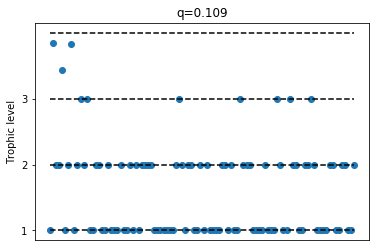

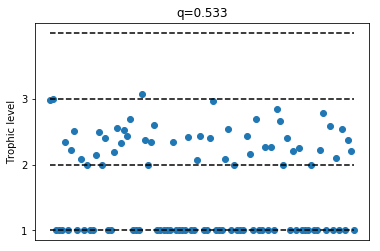

In [611]:
B=50; ##Basal species
S=100; ##Total species
C=.1; ##Complexity
Tvec=[0.01,10]; ##Trophic specialitzation

for kk in xrange(len(Tvec)):
    
    T=Tvec[kk];

    G, A, sl = PPM(B,S,C,T);

    X=0;
    for ii in xrange(S):
        for jj in xrange(S):
            if A[ii,jj] == 1: 
                x = sl[ii] - sl[jj]; x = x**2; 
                X = X + x;
    q=np.sqrt(X/sum(sum(A)) - 1);

    np.random.shuffle(sl);
    
    plt.figure(kk+1);
    
    plt.plot(sl,'o');
    plt.ylabel('Trophic level');
    plt.title('q='+str(round(q,3)));
    plt.yticks(np.arange(1, int(max(sl))+1, 1.0))
    plt.xticks(np.arange(0, 0, 1))
    plt.plot(np.ones(len(sl)),'--k');
    plt.plot(np.ones(len(sl))*2,'--k');
    plt.plot(np.ones(len(sl))*3,'--k');
    plt.plot(np.ones(len(sl))*4,'--k');

In [613]:
B=50; ##Basal species
S=100; ##Total species
C=.1; ##Complexity
N=50; mu=0.2;

M=100;

Tvec=np.linspace(0.01,2.5,N); ##Trophic specialitzation
qvec=np.zeros(N);
sdqvec=np.zeros(N);
Rvec=np.zeros(N);
sdRvec=np.zeros(N);

for kk in xrange(N):
    
    T=Tvec[kk]
    qex=np.zeros(M);
    Rex=np.zeros(M);
    for nn in xrange(M):
        G, A, sl = PPM(B,S,C,T);

        X=0;
        for ii in xrange(S):
            for jj in xrange(S):
                if A[ii,jj] == 1: 
                    x = sl[ii] - sl[jj]; x = x**2; 
                    X = X + x;
                    
        q = np.sqrt(X/sum(sum(A)) - 1);
        qex[nn] = q;

        ##Eigenvec R
        W = mu*A-np.transpose(A);
        lamb = la.eigvals(W); 
        R = max(np.real(lamb));
        Rex[nn] = R;
        
    qvec[kk] = sum(qex)/M;
    sdqvec[kk] = (sum((qex-qvec[kk])**2)/M)**.5;
    
    Rvec[kk] = sum(Rex)/M;
    sdRvec[kk] = (sum((Rex-Rvec[kk])**2)/M)**.5;

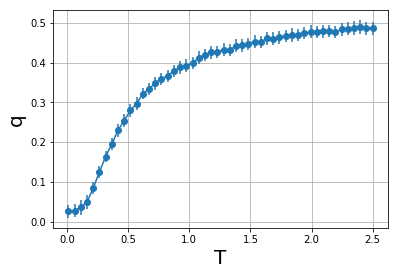

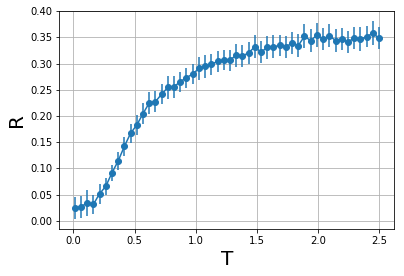

In [614]:
plt.figure(1);
plt.errorbar(Tvec,qvec,(sdqvec/M)**.5, ls='-', marker='o');
plt.ylabel('q',fontsize=20);
plt.xlabel('T',fontsize=20);
plt.grid()

plt.figure(2);
plt.errorbar(Tvec,Rvec,(sdRvec/M)**.5, ls='-', marker='o');
plt.ylabel('R',fontsize=20);
plt.xlabel('T',fontsize=20);
plt.grid()